<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Quark_Gluon_Dataset_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# 1. Imports and File Paths

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
DATA_DIR = "/content/drive/MyDrive/quark-gluon-dataset"
FILES = [
    "quark-gluon_train-set_n793900.hdf5",
    "quark-gluon_test-set_n139306.hdf5",
    "quark-gluon_test-set_n10000.hdf5"
]
FILE_PATHS = [f"{DATA_DIR}/{fname}" for fname in FILES]
FILE_LABELS = ["Train", "Test1", "Test2"]

In [2]:
# 2. Function to Load a Subset from Any File

def load_subset_general(h5_path, N=1000):
    with h5py.File(h5_path, "r") as f:
        keys = list(f.keys())
        if "X_jets" in keys:
            X = np.array(f["X_jets"][:N])
            m0 = np.array(f["m0"][:N])
            pt = np.array(f["pt"][:N])
        elif "X" in keys:
            X = np.array(f["X"][:N])
            m0 = None
            pt = None
        else:
            raise KeyError("No valid feature key found in file.")
        y = np.array(f["y"][:N])
    return X, y, m0, pt

In [3]:
# 3. Print Keys and Shapes for All Files

for path, label in zip(FILE_PATHS, FILE_LABELS):
    with h5py.File(path, "r") as f:
        print(f"\n--- {label} File ---")
        keys = list(f.keys())
        print("Keys:", keys)
        if "X_jets" in keys:
            print("X_jets shape:", f["X_jets"].shape)
        if "X" in keys:
            print("X shape:", f["X"].shape)
        if "y" in keys:
            print("y shape:", f["y"].shape)
        if "m0" in keys:
            print("m0 shape:", f["m0"].shape)
        if "pt" in keys:
            print("pt shape:", f["pt"].shape)


--- Train File ---
Keys: ['X_jets', 'm0', 'pt', 'y']
X_jets shape: (793900, 125, 125, 3)
y shape: (793900,)
m0 shape: (793900,)
pt shape: (793900,)

--- Test1 File ---
Keys: ['X_jets', 'm0', 'pt', 'y']
X_jets shape: (139306, 125, 125, 3)
y shape: (139306,)
m0 shape: (139306,)
pt shape: (139306,)

--- Test2 File ---
Keys: ['X', 'y']
X shape: (10000, 125, 125, 3)
y shape: (10000,)


In [4]:
# 4. Load Subsets for Analysis

N = 50000  # Number of samples per file for analysis
datasets = [load_subset_general(path, N) for path in FILE_PATHS]

Train: Quark: 25001, Gluon: 24999
Test1: Quark: 24981, Gluon: 25019
Test2: Quark: 5000, Gluon: 5000


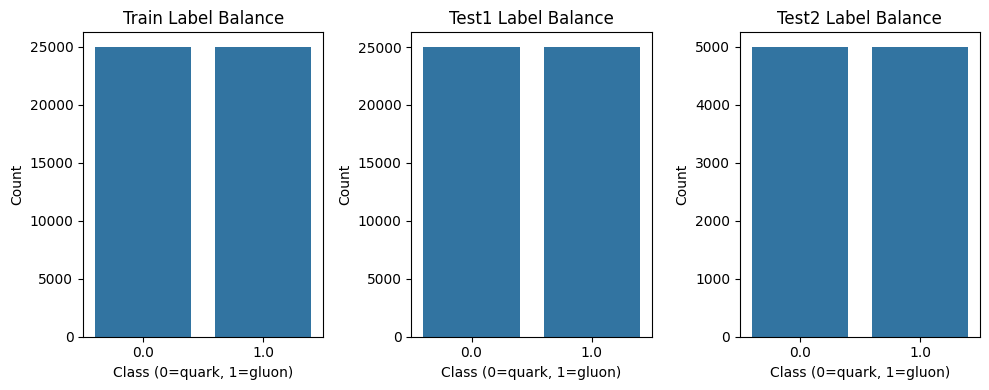

In [5]:
# 5. Plot Label Balance for All Files

plt.figure(figsize=(10, 4))
for i, (X, y, m0, pt) in enumerate(datasets):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=y)
    plt.title(f"{FILE_LABELS[i]} Label Balance")
    plt.xlabel("Class (0=quark, 1=gluon)")
    plt.ylabel("Count")
    plt.tight_layout()
    print(f"{FILE_LABELS[i]}: Quark: {(y==0).sum()}, Gluon: {(y==1).sum()}")
plt.show()

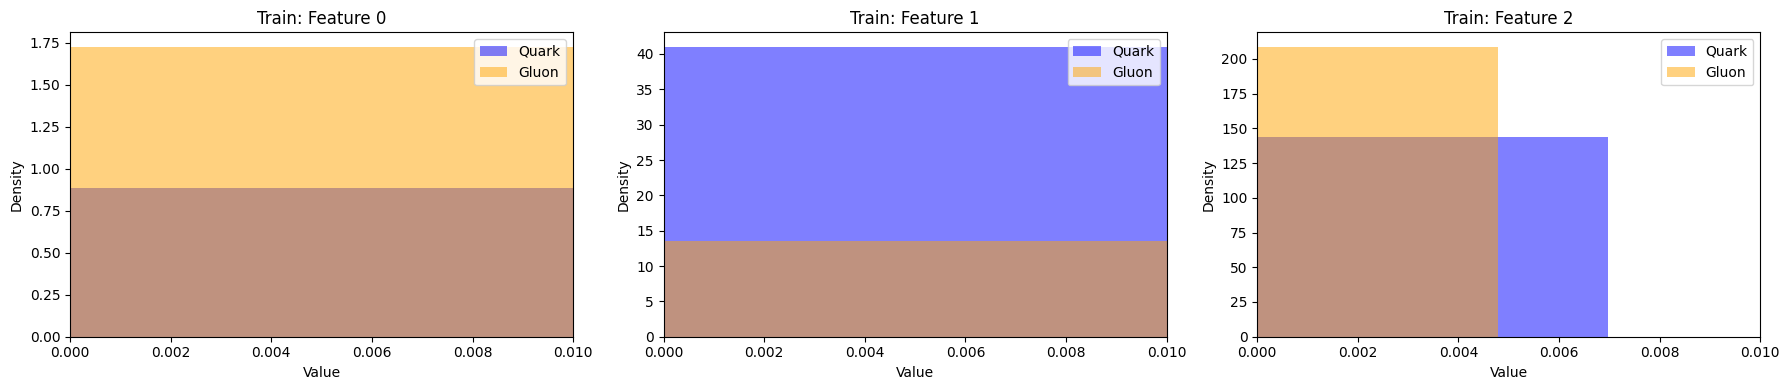

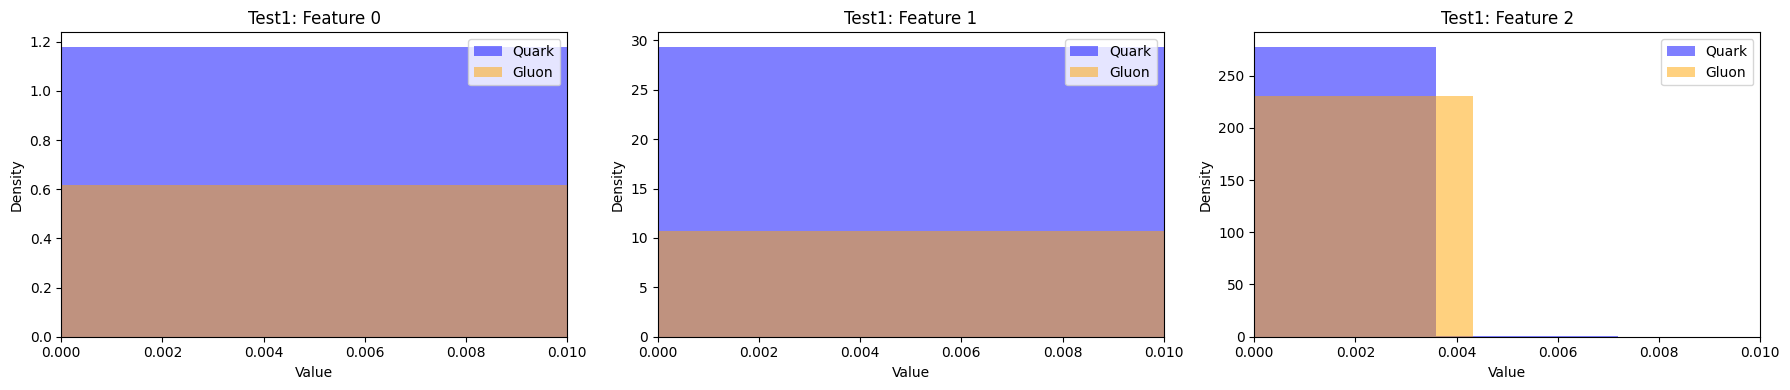

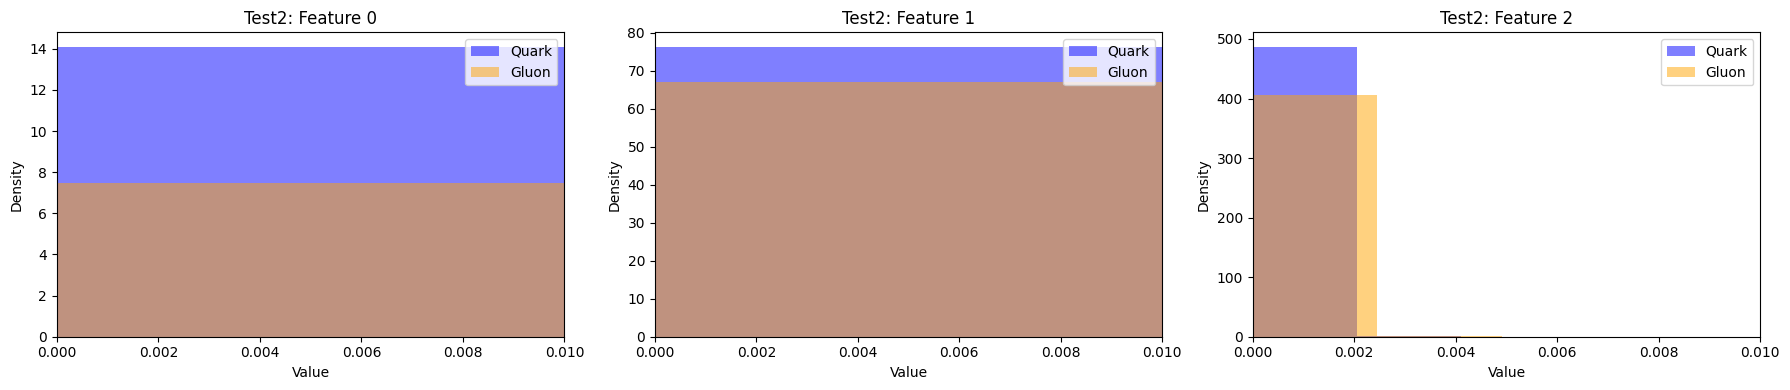

In [6]:
# 6. Channel-wise Value Distributions (Zoomed In) for All Files

channel_names = ["Feature 0", "Feature 1", "Feature 2"]
num_channels = 3
xmaxs = [0.01, 0.01, 0.01]  # Adjust as needed

for i, (X, y, m0, pt) in enumerate(datasets):
    # For Test2, X may be (N, 125, 125, 3) or (N, 3, 125, 125) or (N, features)
    if X.ndim == 4:
        # (N, 125, 125, 3) or (N, 3, 125, 125)
        if X.shape[-1] == 3:
            pass  # (N, 125, 125, 3)
        elif X.shape[1] == 3:
            X = np.transpose(X, (0, 2, 3, 1))  # (N, 125, 125, 3)
        else:
            print(f"Skipping channel-wise plot for {FILE_LABELS[i]}: X shape {X.shape}")
            continue
    else:
        print(f"Skipping channel-wise plot for {FILE_LABELS[i]}: X shape {X.shape}")
        continue

    fig, axs = plt.subplots(1, num_channels, figsize=(6 * num_channels, 4))
    for ch in range(num_channels):
        for label, name, color in zip([0, 1], ["Quark", "Gluon"], ["blue", "orange"]):
            data = X[y == label, :, :, ch].flatten()
            axs[ch].hist(data, bins=100, alpha=0.5, label=name, color=color, density=True)
        axs[ch].set_title(f"{FILE_LABELS[i]}: {channel_names[ch]}")
        axs[ch].set_xlabel("Value")
        axs[ch].set_ylabel("Density")
        axs[ch].set_xlim(0, xmaxs[ch])
        axs[ch].legend()
    plt.tight_layout()
    plt.show()

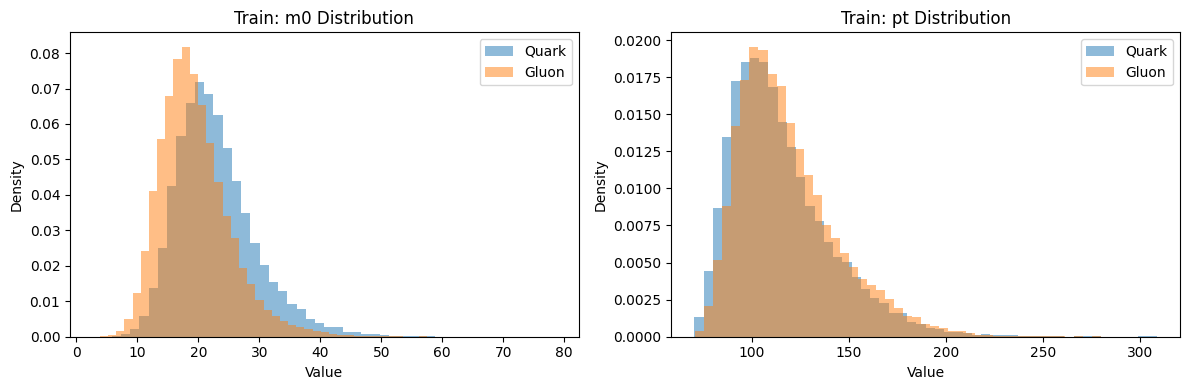

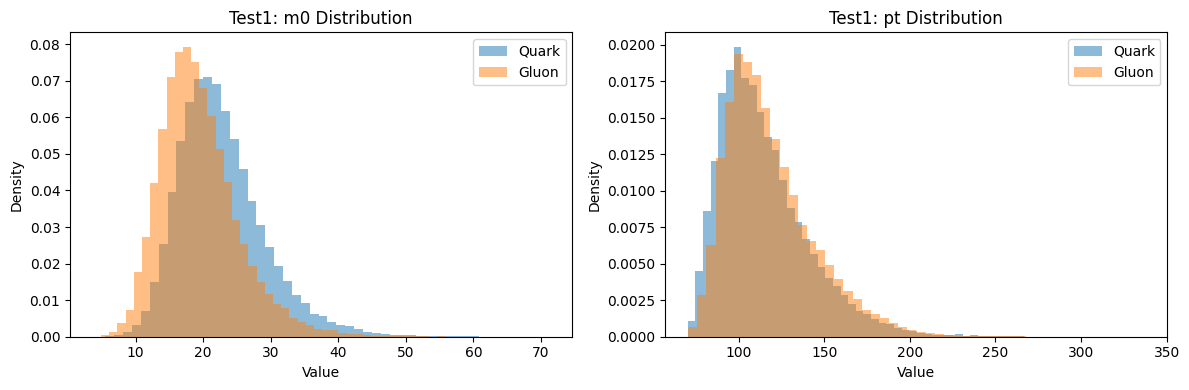

Skipping m0/pt plot for Test2 (not available)


In [7]:
# 7. m0 and pt Distributions for All Files

for i, (X, y, m0, pt) in enumerate(datasets):
    if m0 is None or pt is None:
        print(f"Skipping m0/pt plot for {FILE_LABELS[i]} (not available)")
        continue
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    for label, name in zip([0,1], ["Quark", "Gluon"]):
        axs[0].hist(m0[y==label], bins=50, alpha=0.5, label=name, density=True)
        axs[1].hist(pt[y==label], bins=50, alpha=0.5, label=name, density=True)
    axs[0].set_title(f"{FILE_LABELS[i]}: m0 Distribution")
    axs[1].set_title(f"{FILE_LABELS[i]}: pt Distribution")
    for ax in axs:
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend()
    plt.tight_layout()
    plt.show()

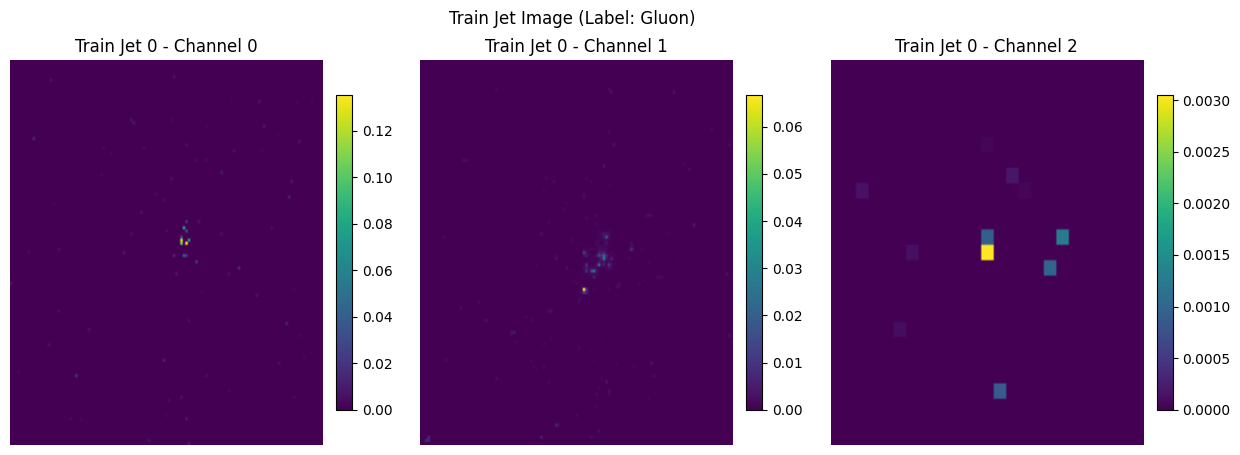

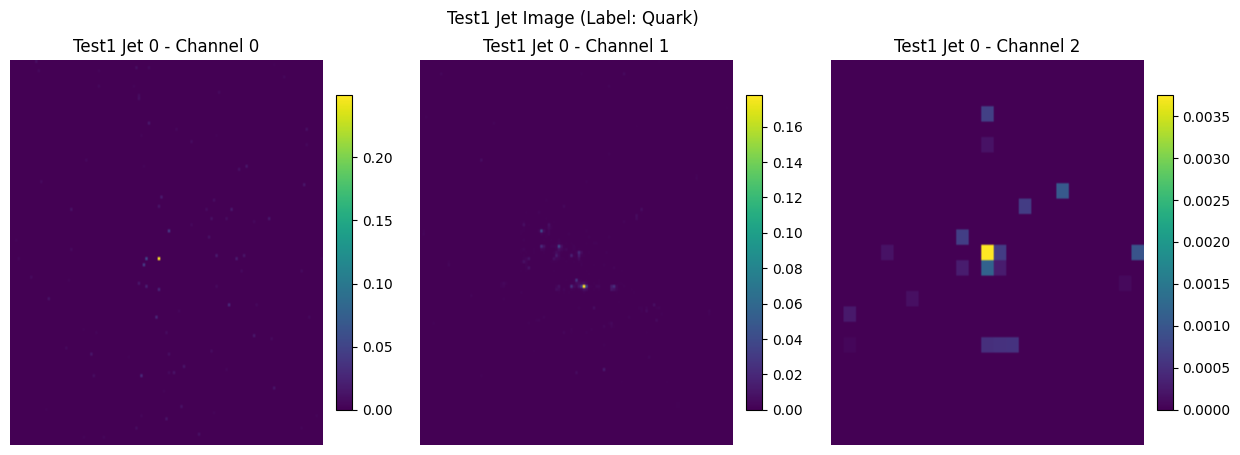

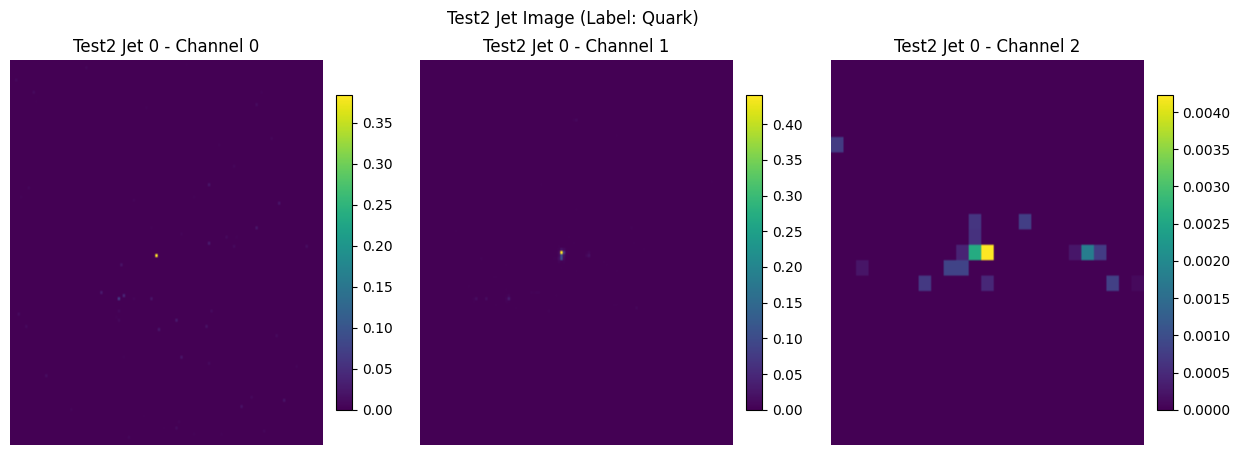

In [8]:
# 8. Visualize Example Jet Images from Each File

for i, (X, y, m0, pt) in enumerate(datasets):
    if X.ndim == 4:
        if X.shape[-1] == 3:
            pass
        elif X.shape[1] == 3:
            X = np.transpose(X, (0, 2, 3, 1))
        else:
            print(f"Skipping image plot for {FILE_LABELS[i]}: X shape {X.shape}")
            continue
        sample_idx = 0
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        for ch in range(3):
            im = axs[ch].imshow(X[sample_idx, :, :, ch], aspect='auto', cmap='viridis')
            axs[ch].set_title(f"{FILE_LABELS[i]} Jet {sample_idx} - Channel {ch}")
            axs[ch].axis('off')
            plt.colorbar(im, ax=axs[ch], fraction=0.046, pad=0.04)
        plt.suptitle(f"{FILE_LABELS[i]} Jet Image (Label: {'Quark' if y[sample_idx]==0 else 'Gluon'})")
        plt.show()
    else:
        print(f"Skipping image plot for {FILE_LABELS[i]}: X shape {X.shape}")